# Install TA Lib

In [1]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 266kB 2.7MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.18-cp36-cp36m-linux_x86_64.whl size=1531848 sha256=8b192158801a5a0e33296c1915169c516a17352db51684d26c2b44fb3c2e123e
  Stored in directory: /root/.cache/pip/wheels/11/cc/88/20dc42c28a07efb297dad4303948ef6dd4a3c7257553db8f09
Successfully built ta-lib


# Imports

In [2]:
import re
import time
import random
import copy
import numpy as np
import pandas as pd
import chainer
from chainer import serializers
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
import talib as ta

# Google Drive Configuration

In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
%cd /content/drive/My Drive/ColabNotebooks/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/ColabNotebooks


# Backtester Class

In [170]:
class _Backtest:
    
    def __init__(self, df, idx_pairs, h2l_std,
                 commission=1.2e-4,
                 feature_len=51,
                 holding_max_t=200,
                 take_profit=False,
                 tp_multiplier=3):

        self.idx_pairs = idx_pairs
        self.h2l_std = h2l_std
        self.commission = commission
        self.feature_len = feature_len
        self.holding_max_t = holding_max_t
        self.take_profit = take_profit
        self.tp_multiplier = tp_multiplier

        self._data = df.to_numpy(dtype=np.float64).T
        self._data_len = self._data.shape[1]
        self._H = self._data[1]
        self._L = self._data[2]
        self._C = self._data[3]

        self.rsi_period = 14
        self.fastk_period = 14
        self.slowk_period = 3
        self.ind_lb = 10 # indicator lookback period

        self.rsi_C = ta.RSI(self._C, timeperiod=self.rsi_period)
        self.rsi_H = ta.RSI(self._H, timeperiod=self.rsi_period)
        self.rsi_L = ta.RSI(self._C, timeperiod=self.rsi_period)
        self.stoch_k, self.stoch_d =\
            ta.STOCH(self._H, self._L, self._C, fastk_period=self.fastk_period, slowk_period=self.slowk_period)

        self.rsi_C_cat =\
            lambda i: [self.categorize(self.rsi_C[i-x]) if i > self.rsi_period * 2 else -30 for x in range(self.ind_lb)]
        self.all_rsi_C_cat = [self.rsi_C_cat(i) for i in range(self._data_len)]

        self.rsi_H_cat =\
            lambda i: [self.categorize(self.rsi_H[i-x]) if i > self.rsi_period * 2 else -30 for x in range(self.ind_lb)]
        self.all_rsi_H_cat = [self.rsi_H_cat(i) for i in range(self._data_len)]

        self.rsi_L_cat =\
            lambda i: [self.categorize(self.rsi_L[i-x]) if i > self.rsi_period * 2 else -30 for x in range(self.ind_lb)]
        self.all_rsi_L_cat = [self.rsi_L_cat(i) for i in range(self._data_len)]

        self.stoch_k_cat =\
            lambda i: [self.categorize(self.stoch_k[i-x]) if i > self.fastk_period * 2 + self.slowk_period else -30 for x in range(self.ind_lb)]
        self.all_stoch_k_cat = [self.stoch_k_cat(i) for i in range(self._data_len)]

        self.stoch_d_cat =\
            lambda i: [self.categorize(self.stoch_d[i-x]) if i > self.fastk_period * 2 + self.slowk_period else -30 for x in range(self.ind_lb)]
        self.all_stoch_d_cat = [self.stoch_d_cat(i) for i in range(self._data_len)]

        self.stoploss = self.all_SL()
        
        self.reset()
        
    def reset(self):
        """
        resets all position/history states and features
        """
        self.t_i = 0 # index for idx_pairs
        self.t = self.idx_pairs[self.t_i][0] # chooses beginning of first index pair
        self.t_in_pos = 0 # time in position
        self.sl_distance = 0 # stoploss distance
        self.done = False
        self.pnl_r = [] # profit/losses tracking in R's
        self.positions = [] # stores entry prices of positions
        self.isLong = True # is the state of the direction of the trade
        self.position_sl = 0
        self.position_tp = 0
        self.open_pos = 0
        self.tp_mult = 0
        
        # position value in price difference
        self.position_value = 0

        # self.history = [0 for _ in range(self.feature_len-1)]
        # initialize environment array
        return [self.position_value] + [-30 for _ in range(self.ind_lb)] * 5
        # return [self.position_value] + self.history
    
    def true_range(self, i):
        return max(self._H[i]-self._L[i],
                    abs(self._H[i]-self._C[i-1]),
                    abs(self._L[i]-self._C[i-1]))
    
    def all_SL(self):
        # standard deviation of h2l/c moving average
        tr, sl = [np.nan], [self._C[0] * self.h2l_std * 4]
        for i in range(1,self._data_len):
            tr.append(self.true_range(i))
            if len(tr) == 31:
                sl.append(np.mean(tr[-30:]) * 2)
                tr.pop(0)
            else:
                sl.append(self._C[i] * self.h2l_std * 4)
                
        return sl
    
    def categorize(self, number, sep=5):
        return round(number // sep) * sep

    def go_short(self):
        self.positions.append(self._C[self.t])
        self.set_sl_tp_short()
        self.isLong = False
        self.open_pos = len(self.positions)
        
    def go_long(self):
        self.positions.append(self._C[self.t])
        self.set_sl_tp_long()
        self.isLong = True
        self.open_pos = len(self.positions)
        
    def set_sl_tp_long(self):
        entry = self.entry_price()
        self.position_sl = entry - self.stoploss[self.t] # * (3 / len(self.positions))
        self.sl_distance = entry - self.position_sl
        if self.take_profit:
            self.position_tp = entry + self.sl_distance * self.tp_multiplier # * (3 / len(self.positions))

    def set_sl_tp_short(self):
        entry = self.entry_price()
        self.position_sl = entry + self.stoploss[self.t] # * (3 / len(self.positions))
        self.sl_distance = self.position_sl - entry
        if self.take_profit:
            self.position_tp = entry - self.sl_distance * self.tp_multiplier # * (3 / len(self.positions))

    def sl_is_hit_short(self):
        return self._H[self.t] >= self.position_sl

    def sl_is_hit_long(self):
        return self._L[self.t] <= self.position_sl

    def tp_is_hit_long(self):
        return self._H[self.t] > self.position_tp

    def tp_is_hit_short(self):
        return self._L[self.t] < self.position_tp

    def entry_price(self):
        return np.mean(self.positions)

    def register_closed_pos(self, reward_d, state):
        """
        reward_d: reward distance in points
        """
        cost = self._C[self.t] * self.commission * 2

        # the reward/risk of the closed position
        rr = 1
        if self.sl_distance != 0:
            rr = round( ( (reward_d - cost) / self.sl_distance ) * 100)

        # add profits in R to pnl_r list
        self.pnl_r.append(rr/100)

        # no open position anymore
        self.positions = []
        self.open_pos = 0
        self.t_in_pos = 0
        
        return rr
    
    def step(self, act):
        """
        0: do nothing
        1: go long
        2: go short
        """
        reward = 0 # negative reward for doing nothing
        
        self.position_value = 0

        if self.open_pos > 0:
            if self.isLong:
                self.position_value = self._C[self.t] - self.entry_price()
                if self.sl_is_hit_long():
                    reward = self.register_closed_pos(-self.sl_distance, "stopped out")
                elif self.take_profit and self.tp_is_hit_long():
                    reward = self.register_closed_pos(self.sl_distance * self.tp_multiplier, "tp is hit")
                elif act == 2:
                    reward = self.register_closed_pos(self.position_value, "closed by Agent")
            else:
                self.position_value = self.entry_price() - self._C[self.t]
                if self.sl_is_hit_short():
                    reward = self.register_closed_pos(-self.sl_distance, "stopped out")
                elif self.take_profit and self.tp_is_hit_short():
                    reward = self.register_closed_pos(self.sl_distance * self.tp_multiplier, "tp is hit")
                elif act == 1:
                    reward = self.register_closed_pos(self.position_value, "closed by Agent")
        elif act == 1:
            self.go_long()
        elif act == 2:
            self.go_short()
        
        # punish too long holding times
        # if self.t_in_pos > self.holding_max_t:
            # reward -= 20

        # counts up the time index 'self.t' and the idx_pair index 'self.t_i'
        if self.t < self.idx_pairs[self.t_i][1]: # if inside interval
            self.t += 1
        else:
            if self.open_pos > 0:
                # closes the position at end of idx_pair intervall (session)
                reward = self.register_closed_pos(self.position_value, "end of session")
            if self.t_i < len(self.idx_pairs)-1:
                self.t_i += 1
                self.t = self.idx_pairs[self.t_i][0]

        rsi_features = self.all_rsi_C_cat[self.t] + self.all_rsi_H_cat[self.t] + self.all_rsi_L_cat[self.t]
        stoch_features = self.all_stoch_k_cat[self.t] + self.all_stoch_d_cat[self.t]
        
        return [self.position_value] + stoch_features + rsi_features, reward, self.done # obs, reward, done

# Helper Functions

In [113]:
def parse_datestring_d_m(s):
    # s = 29/05/2000 02:05:00
    p = re.compile(r"(\d{2})[-/]\d{2}[-/](\d{4}) \d{2}:\d{2}:\d{2}")
    return np.array(p.match(s).groups(), dtype=int) # day, month


def parse_datestring_h_m(s):
    # s = 29/05/2000 02:05:00
    p = re.compile(r"\d{2}[-/]\d{2}[-/]\d{4} (\d{2}):(\d{2}):\d{2}")
    return np.array(p.match(s).groups(), dtype=int) # hour, minute


def slice_df_to_weeks(_df):
    """
    return: pairs of [begin,end] intervals, that can be accessed with
    index >= begin and index < end
    """
    df_slice_pairs = []
    last_slice_begin = 0
    dates = list(_df.index.values)
    new_day = 0
    for t in range(1, len(_df)):
        if parse_datestring_d_m(dates[t])[0] != parse_datestring_d_m(dates[t-1])[0]:
            new_day += 1
            if new_day % 7 == 0:
                df_slice_pairs.append([last_slice_begin,t])
                last_slice_begin = t
    print("new days",new_day)
    print(df_slice_pairs[:10])
    return df_slice_pairs


def slice_df_to_quarters(_df):
    """
    return: pairs of [begin,end] intervals, that can be accessed with
    index >= begin and index < end
    """
    qbm = list(range(1,12,3)) # quarter beginning month
    df_slice_pairs = []
    quarter_count = 0
    last_slice_begin = 0
    for t in range(1, len(_df)):
        if _df.iloc[t].name.day < _df.iloc[t-1].name.day and _df.iloc[t].name.month in qbm:
            df_slice_pairs.append([last_slice_begin,t])
            last_slice_begin = t
            quarter_count += 1
    return df_slice_pairs


def test_date_output(_df):
    dates = list(_df.index.values)
    return parse_datestring_d_m(dates[5])[0], parse_datestring_h_m(dates[5])[0] 

    
def plot_pnl_stats(Q, **kwargs):
    """
    Q: Q-Network with its specific hyperparameters and/or dueling / double q
    mechanism
    **kwargs: Environments with name = environment
    """
    for _name, _env in kwargs.items():
        # the reset function loads the history into this variable
        pobs = _env.reset()
        stepmax = sum([s[1] - s[0] for s in _env.idx_pairs])-1

        for _ in range(stepmax):
        
            pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
            pact = np.argmax(pact.data)
            obs, reward, done = _env.step(pact)
            pobs = obs
        
        # stat calculations: 
        _equity = [0,]
        profits = []
        losses = []
        trade_count = 0
        highest = 0
        highest_rel_dd = 0
        for r_pnl in _env.pnl_r:
            _equity.append(_equity[-1] + r_pnl)
            if r_pnl > 0:
               profits.append(r_pnl)
               trade_count += 1
            else:
                losses.append(r_pnl)
                trade_count += 1
            if _equity[-1] > highest:
                highest = _equity[-1]
                    
            if _equity[-1] < highest:
                dd = highest - _equity[-1]
                if dd > highest_rel_dd:
                    highest_rel_dd = dd
        
        steps = list(range(1,len(_equity)+1))
        plt.plot(steps, _equity)
        
        plt.xlabel('Trades')
        plt.ylabel('R Multiples')
        plt.title(_name+' Equity')
        plt.show()
        
        #print out stats
        hr, avgp, avgl = len(profits)/trade_count, np.mean(profits), abs(np.mean(losses))
        total_profit = sum(_env.pnl_r)
        print(_env.pnl_r) # optional: can print out all pnl_r values in a list
        print(_name,"Stats\n########################\n")
        print('R Profits:',round(total_profit,2))
        print('Trades:',len(profits)+len(losses))
        print('Hitrate:',round(hr,2))
        print('Average Loss:',round(avgl,2))
        print('Average Risk/Reward:',round(avgp/avgl,2))
        print('Profit Factor:',round((avgp*hr)/(avgl*(1-hr)),2))
        print('Biggest Rel. DD:',round(highest_rel_dd,2),)
        print('Gain/DD Ratio:',round(total_profit/highest_rel_dd,2),'\n')

def SQN_calc(Q, _env):
    # the reset function loads the history into this variable
    pobs = _env.reset()
    stepmax = sum([s[1] - s[0] for s in _env.idx_pairs])-1

    for _ in range(stepmax):

        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        obs, reward, done = _env.step(pact)
        pobs = obs

    # SQN= Squareroot(N) * Average (of the N Profit&Loss) / Std dev (of the N Profit&Loss).

    return round(np.sqrt(len(_env.pnl_r)) * np.mean(_env.pnl_r) / np.std(_env.pnl_r),2)

# Q Network

In [159]:
def build_empty_dddqn(env):
    class Q_Network(chainer.Chain):
        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)],
                               axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)],
                                                                     axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    
    return Q_Network(input_size=env.feature_len, hidden_size=100, output_size=3)


# Dueling Double DQN
def train_dddqn(env,name,startQ=None,
                mem_size = 0.075,
                update_q_rel = 1,
                train_freq_rel = 0.5,
                batch_size_rel = 0.25,
                eps_decr_p = 0.8,
                gamma = 0.965):
  
    """ <<< Double DQN -> Dueling Double DQN
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    === """
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            """
            Build a network that maps state -> action values
            """
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.feature_len, hidden_size=100, output_size=3)
    if startQ is not None:
        Q = startQ
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    # data points
    step_max = sum([s[1] - s[0] for s in env.idx_pairs])-1
    memory_size = int(round(mem_size * step_max))
    update_q_freq = int(round(memory_size * update_q_rel))
    train_freq = int(round(update_q_freq * train_freq_rel))
    batch_size = int(round(train_freq * batch_size_rel))
    epsilon = 1.0
    epsilon_min = 0.1
    # going down 0.9 after start_reduce_epsilon to 90% of data
    epsilon_decrease = (epsilon-epsilon_min) / round(step_max * eps_decr_p)
    start_reduce_epsilon = round(step_max * 0.2) # ~ 20% of data

    print('step_max', step_max, 'memory_size', memory_size, 'update_q_freq', update_q_freq,
          'train_freq', train_freq, 'batch_size', batch_size, 'gamma', gamma)

    memory = []
    total_step = 0

    start = time.time()

    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:

        # select act
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:
            pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
            pact = np.argmax(pact.data)

        # act
        obs, reward, done = env.step(pact)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q = exploit or explore
        if len(memory) == memory_size:
            if total_step % train_freq == 0:

                shuffled_memory = np.random.permutation(memory)
                
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(b_pobs)

                    """ <<< DQN -> Double DQN
                    maxq = np.max(Q_ast(b_obs).data, axis=1)
                    === """
                    indices = np.argmax(q.data, axis=1)
                    maxqs = Q_ast(b_obs).data
                    """ >>> """
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        """ <<< DQN -> Double DQN
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        === """
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                        """ >>> """
                    Q.reset()
                    loss = F.mean_squared_error(q, target)
                    total_loss += loss.data
                    loss.backward()
                    optimizer.update()

            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)

        # epsilon
        if epsilon > epsilon_min and total_step > start_reduce_epsilon:
            epsilon -= epsilon_decrease

        # next step
        total_reward += reward
        pobs = obs
        step += 1
        total_step += 1

    return Q

# Data Preparation

In [73]:
len(data)

3432

In [169]:
stock_name = "Other Files/BTC_15m_clean"
data = pd.read_pickle(stock_name)
h2l_std = 0.0081
print("Data rows:", len(data))
print('(day, hour)', test_date_output(data))
data.head()

"""
stock_name = 'DJIA'
data = pd.read_csv(stock_name+'.csv')
print(data.head())
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print('Data range from:',data.index.min(),"to",data.index.max(),'\n')

# Calculate the high to low diffrence in percentages to close price
# to then compute standard deviation from all the 'h2l_ps'
h2l_ps = []
for index, row in data.iterrows():
    h2l_ps.append((row['High'] - row['Low']) / row['Close'])
    
h2l_std = np.std(h2l_ps)
"""
data.head()

Data rows: 103002
(day, hour) (31, 9)


,Open,High,Low,Close
Date,,,,
31/12/2011 08:00:00,4.39,4.39,4.39,4.39
31/12/2011 08:15:00,4.39,4.39,4.39,4.39
31/12/2011 08:30:00,4.39,4.39,4.39,4.39
31/12/2011 08:45:00,4.39,4.39,4.39,4.39
31/12/2011 09:00:00,4.39,4.39,4.39,4.39


# Data Seperation

In [119]:
# slices all data to [beginning, end] interval pairs to quarter intervals
slice_all = slice_df_to_weeks(data)

# shuffles the order of the [begining, end] interval pairs
slice_all = np.random.permutation(slice_all)

# seperates all slices into two different arrays s_trids and s_teids 
total_slices = len(slice_all)

# Leave out 20% data
half_slices = total_slices * 10 // 12

# s_trids: slice of training interval ID's, s_teids: slice of testing interval ID's
s_trids, s_teids  = slice_all[:half_slices], slice_all[half_slices:]

# uncomment this to load slices from npy file
# s_trids, s_teids = np.load("s_trids_1.npy"), np.load("s_teids_1.npy")

# uncomment this to not save slices in npy files
np.save("s_trids_1", s_trids, allow_pickle=True)
np.save("s_teids_1", s_teids, allow_pickle=True)

len(s_trids), len(s_teids)

new days 3030
[[0, 214], [214, 452], [452, 690], [690, 928], [928, 1166], [1166, 1404], [1404, 1642], [1642, 1880], [1880, 2118], [2118, 2356]]


(360, 72)

# Environment Creation

In [171]:
env = _Backtest(data,s_trids,h2l_std)

# Model Creation & Testing

In [173]:
MAKE_MODEL = True

# build an empty network first to copy the loaded Q Object in
Q = build_empty_dddqn(env) # for Dueling Double Q Learning

if MAKE_MODEL:
    # startq = serializers.load_npz('Name', Q) # for starting where you left
    Q = train_dddqn(env, stock_name, startQ=None, mem_size=0.0057) # Dueling Double Q Learning training
    # serializers.save_npz('DDDQN_'+stock_name+'_3', Q) # saves the model
    serializers.save_npz('DDDQN_BTCUSD_1', Q) # saves the model
    print('SQN:',SQN_calc(Q, env),'Val SQN:',SQN_calc(Q, _Backtest(data,s_teids,h2l_std)))
    # plots losses/rewards of every epoch
else:
    serializers.load_npz('DDDQN_'+stock_name+'_3', Q) # only loads the model

step_max 85627 memory_size 488 update_q_freq 488 train_freq 244 batch_size 61 gamma 0.965
SQN: 7.33 Val SQN: 7.89


# Plots

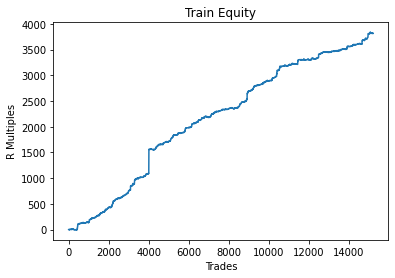

[-0.05, 0.1, -0.05, -0.09, -1.03, -1.03, 0.1, -1.02, -0.3, 0.21, 0.18, -0.02, 0.0, -1.02, 0.9, 0.1, 0.0, 0.27, -0.0, -0.17, 0.04, -0.11, 2.27, 0.48, 0.53, -0.04, 0.61, 0.28, 0.48, 0.32, -0.05, -0.19, 0.53, 0.86, -0.4, 0.48, 0.34, 0.19, 0.1, -0.25, 0.07, -0.15, -0.9, -1.02, -1.02, 0.1, -1.02, 0.31, -0.08, -1.02, -1.02, -1.02, 0.87, 1.0, 0.34, 0.54, 0.65, -1.03, 1.02, -0.34, -0.17, 1.9, -0.04, 0.04, 0.24, -0.11, -0.05, 0.08, 0.69, 4.43, 0.71, -0.1, -0.22, -0.12, 0.37, -0.02, 0.19, 0.17, 0.66, 0.7, 1.66, 0.86, -1.02, 0.36, -0.05, 0.52, 0.46, 0.11, 0.14, 0.24, -0.45, 0.31, 0.27, 0.14, 0.05, -1.02, -1.02, -1.01, -1.01, -1.01, 0.19, -1.01, 0.22, 0.35, 0.24, -1.01, -0.04, -1.01, -1.03, -1.02, 0.49, -0.05, 0.2, -0.3, 0.27, 0.1, 0.25, -1.02, 0.6, 0.18, 0.29, 0.15, 0.68, -1.02, -1.01, 0.27, -0.23, 0.07, -0.35, 0.22, -0.28, 0.26, -1.02, 0.6, -1.04, 0.92, 0.16, 0.69, 0.39, -0.16, -0.11, -0.7, 0.64, -0.71, 1.0, 0.38, 2.1, -1.03, -0.26, -0.16, 0.8, 0.47, -0.13, 0.12, -1.07, -1.06, 0.56, -1.07, 0.6, 

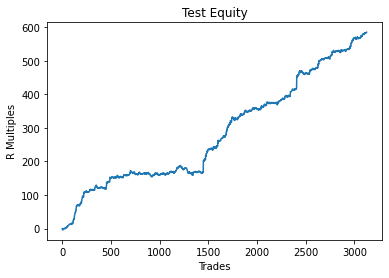

[-1.02, -1.02, -1.02, -1.02, 1.81, 0.14, -0.84, 0.13, 0.59, 0.67, 0.24, 1.08, -0.13, 0.21, -0.16, -0.02, -0.32, 0.14, 0.13, 0.02, -0.64, 0.2, 0.54, 0.74, 0.25, 0.09, -0.01, 0.0, -1.01, 0.23, 1.6, 0.88, 0.38, -0.04, -1.02, 0.06, -1.02, 0.85, 0.42, 0.74, -0.03, -0.1, 1.17, 0.08, 0.33, 0.01, -1.01, -0.08, 1.59, 1.97, -0.02, 0.31, -0.26, 0.35, -0.14, 0.77, -1.02, 0.47, 0.27, 0.78, 0.42, 0.91, 0.51, 0.11, 0.09, 0.36, 0.79, -0.14, 0.25, 0.69, 0.25, 0.27, 0.18, -0.02, -0.08, 0.28, -0.41, 0.0, -0.06, 0.02, -0.33, -0.08, 0.69, 0.14, 0.23, -0.07, 0.18, -1.03, 1.28, 0.57, 0.51, 0.1, -1.03, 1.02, -0.04, 0.03, 0.12, 0.19, 1.03, -1.04, 0.47, -0.0, -1.04, -1.02, 0.62, 1.01, 2.91, -0.02, -1.02, 1.44, 2.36, 1.94, -0.03, 2.06, -1.03, 3.99, 1.01, -0.74, -0.02, -0.02, 0.64, -0.02, 1.47, 7.12, 1.32, 2.34, 0.67, 0.1, 0.71, 1.82, 1.36, 1.66, 2.15, 0.16, -1.05, 1.22, 0.13, -0.06, 3.63, 1.87, -0.08, 1.87, 6.69, 2.09, 1.57, 0.29, 0.24, 0.26, -0.16, 0.02, -0.34, -1.06, 1.55, 0.48, 2.71, -1.04, -0.08, -1.03, -0.0

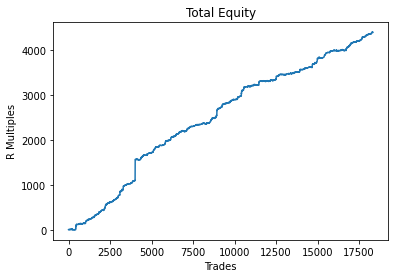

[-0.05, 0.1, -0.05, -0.09, -1.03, -1.03, 0.1, -1.02, -0.3, 0.21, 0.18, -0.02, 0.0, -1.02, 0.9, 0.1, 0.0, 0.27, -0.0, -0.17, 0.04, -0.11, 2.27, 0.48, 0.53, -0.04, 0.61, 0.28, 0.48, 0.32, -0.05, -0.19, 0.53, 0.86, -0.4, 0.48, 0.34, 0.19, 0.1, -0.25, 0.07, -0.15, -0.9, -1.02, -1.02, 0.1, -1.02, 0.31, -0.08, -1.02, -1.02, -1.02, 0.87, 1.0, 0.34, 0.54, 0.65, -1.03, 1.02, -0.34, -0.17, 1.9, -0.04, 0.04, 0.24, -0.11, -0.05, 0.08, 0.69, 4.43, 0.71, -0.1, -0.22, -0.12, 0.37, -0.02, 0.19, 0.17, 0.66, 0.7, 1.66, 0.86, -1.02, 0.36, -0.05, 0.52, 0.46, 0.11, 0.14, 0.24, -0.45, 0.31, 0.27, 0.14, 0.05, -1.02, -1.02, -1.01, -1.01, -1.01, 0.19, -1.01, 0.22, 0.35, 0.24, -1.01, -0.04, -1.01, -1.03, -1.02, 0.49, -0.05, 0.2, -0.3, 0.27, 0.1, 0.25, -1.02, 0.6, 0.18, 0.29, 0.15, 0.68, -1.02, -1.01, 0.27, -0.23, 0.07, -0.35, 0.22, -0.28, 0.26, -1.02, 0.6, -1.04, 0.92, 0.16, 0.69, 0.39, -0.16, -0.11, -0.7, 0.64, -0.71, 1.0, 0.38, 2.1, -1.03, -0.26, -0.16, 0.8, 0.47, -0.13, 0.12, -1.07, -1.06, 0.56, -1.07, 0.6, 

In [174]:
plot_pnl_stats(Q,
               Train=env,
               Test=_Backtest(data, s_teids, h2l_std),
               Total=_Backtest(data, slice_all, h2l_std))